# Sib contact tracing integration

Before the main loop, the events `'sib_tracing'` are added to the event queue, in case `smart_tracing_policy_isolate` and/or `smart_tracing_policy_test` are set to `'sib'`.

In [ ]:
        # initialize contact tracing events: add 'update_test' event to queue
        # !! VALUES STILL HARDCODED !!
        if ('isolate' in self.smart_tracing_actions and self.smart_tracing_policy_isolate == 'sib') or \
               ('test' in self.smart_tracing_actions and self.smart_tracing_policy_test == 'sib'):
            for h in range(5, math.floor(self.max_time / (1.0 * TO_HOURS))):
                ht = h * 1.0 * TO_HOURS + 0.5 * TO_HOURS
                self.queue.push((ht, 'sib_tracing', None, None, None, None), priority=ht)

Now it's necessary to stop the other contact tracing measures if the policies are set to `'sib'`, so in `__process_testing_event`:

In [ ]:
        # if sib contact tracing is active, isolate positive individuals here
        if ('isolate' in self.smart_tracing_actions and self.smart_tracing_policy_isolate == 'sib'):
            self.measure_list.start_containment(SocialDistancingForSmartTracing, t=t, j=i)
            self.measure_list.start_containment(SocialDistancingForSmartTracingHousehold, t=t, j=i)
            self.measure_list.start_containment(SocialDistancingSymptomaticAfterSmartTracing, t=t, j=i)
            self.measure_list.start_containment(SocialDistancingSymptomaticAfterSmartTracingHousehold, t=t, j=i)
        
        # do not process contact tracing if sib contact tracing is active
        sib_contact_tracing = ('isolate' in self.smart_tracing_actions and self.smart_tracing_policy_isolate == 'sib') or \
                              ('test' in self.smart_tracing_actions and self.smart_tracing_policy_test == 'sib')

        # if the individual is tested positive, process contact tracing when active and intended
        if self.state['posi'][i] and (self.smart_tracing_actions != []) and trigger_tracing_if_positive \
           and (not sib_contact_tracing):
            self.__update_smart_tracing(t, i)
            self.__update_smart_tracing_housholds(t, i)

So if `smart_tracing_policy_isolate` or `smart_tracing_policy_test` are different than `'sib'` (`'basic'`, `'advanced'` etc.), the contact tracing is done with those policies.

The results of the tests are saved in the dictionary `all_obs` (a dictionary and not a list since many tests are done at the same time t), which elements are `{t_test: obs_list}`, where `t_test` is the time the results are available and `obs_list` is a list with elements `[i, s, trigger_tracing]` (`i` is the individual, `s` a boolean variable that indicates the result of the test, and `trigger_tracing` is a boolean variable that indicates whether the test should be used for contact tracing).

So in `DiseaseModel.__init_run`:

In [ ]:
        # record all test results
        self.all_obs = {}

and in `__process_testing_event`:

In [ ]:
        # record test result
        if t in self.all_obs:
            self.all_obs[t].append([i, is_positive_test, trigger_tracing_if_positive])
        else:
            self.all_obs[t] = [[i, is_positive_test, trigger_tracing_if_positive]]

where `t` here is the time the test result is available.

Now the `'sib_tracing'` event must be processed, so in the main loop:

In [ ]:
            # check if sib tracing event            
            if event == 'sib_tracing':
                self.__process_sib_tracing_event(t)
                continue

and

In [ ]:
    def __process_sib_tracing_event(self, t):
        # day of the tracing event
        t_day = int(t // TO_HOURS)
        
        # get the time to the last tracing event
        # !! VALUES STILL HARDCODED !!
        t_start = t - 1.0 * TO_HOURS
        
        # if it's the first event, set the last tracing event time to zero
        # !! VALUES STILL HARDCODED !!
        if t_day == 5:
            t_start = 0
        
        # get the new test results
        new_obs = []
        
        times = [th for th in self.all_obs if ((th >=t_start) and (th < t))]
        
        for th in times:
            for test in self.all_obs[th]:
                # use result only if trigger_tracing is True
                if test[2]:
                    # set the time to the test time, discretized
                    # !! VALUES STILL HARDCODED !!
                    test_time = th - self.test_reporting_lag
                    day_temp = int((test_time - 0.5 * TO_HOURS) // TO_HOURS)
                    
                    # day 0 is potentially longer than the others
                    if day_temp < 0:
                        day_temp = 0
                    
                    new_obs.append((test[0], test[1], day_temp))

where the interval `[t_start,t]` is the interval of the new information; `all_obs` saves the times of when the results of the tests are available, and not the times of the tests directly, in ordered to account for the possibility of multiple `test_reporting_lag` (which would have to be saved for each test).

The discretization of time (needed for the sib ranking) follows the scheme:

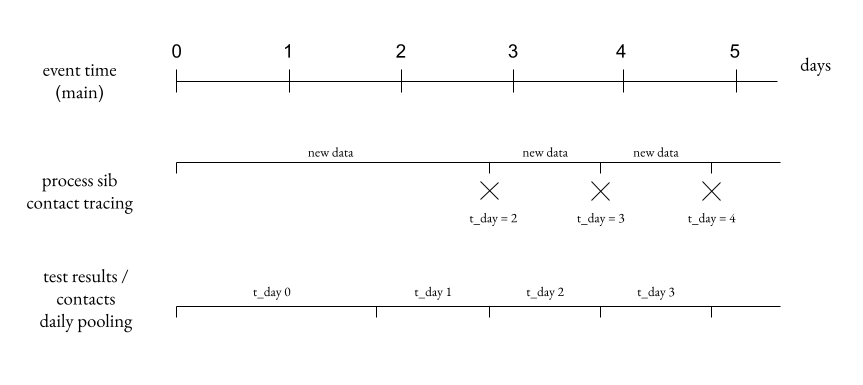

where the x are the sib contact tracing events, and the new data are the new contacts in that period of time and the new test results. The implementation of manual contact tracing would "reveal" contacts that happened in a time window different than the ones reported here.

Continuing ` def __process_sib_tracing_event(self, t)`:

In [ ]:
        # get new contacts of all the individuals
        part_contacts = self.__get_valid_contacts_interval(t_start, t)
        
        contacts_df = pd.DataFrame(part_contacts, columns = ['i','j','t','deltat'])
        
        # add new household contacts
        housedict = self.mob.households
        
        contacts_households = []
   
        for house in housedict.keys():
            people_h = housedict[house]
            for i in people_h:
                for j in people_h:
                    if i!=j:
                        # if it's the first event, add all the contacts in the previous days
                        # !! VALUES STILL HARDCODED !!
                        if t_day == 5:
                            contacts_households += [(i, j, t) for t in range(0, t_day)]
                        else:
                            contacts_households += [(i, j, t_day-1)]

        contacts_households_df = pd.DataFrame(contacts_households,columns = ['i','j','t'])
        # !! VALUES STILL HARDCODED !!
        contacts_households_df['deltat'] = 3
        
        contacts_df = contacts_df.append(contacts_households_df)
        contacts_df = contacts_df.sort_values(by=["t","i","j"])
        
        # compute lambda
        t_unit = int(1.0 * TO_HOURS)
        beta = self.betas_weighted_mean
        contacts_df['lambda'] = 1 - np.exp(-beta * contacts_df['deltat'].to_numpy() / t_unit)
        
        new_contacts = contacts_df[['i','j','t','lambda']].to_records(index = False)
        
        # if it's the first event, add fake observations
        # !! VALUES STILL HARDCODED !!
        if t_day == 5:
            for day in range(5):
                for i in range(self.inference_algo.N):
                    self.inference_algo.f.append_observation(i, -1, day)

        # rank all the individuals
        rank = self.inference_algo.rank(t_day, new_contacts, new_obs)
        
        # sort from highest probability to lowest
        rank = np.array(sorted(rank, key= lambda tup: tup[1], reverse=True))
        
        indv_rank = [int(tup[0]) for tup in rank]
        
        rank_isolate = indv_rank[:self.smart_tracing_isolated_contacts] 
        rank_test = indv_rank[:self.smart_tracing_tested_contacts] 
        
        '''Execute contact tracing actions for selected contacts'''
        if 'isolate' in self.smart_tracing_actions:
            for j in rank_isolate:
                self.measure_list.start_containment(SocialDistancingForSmartTracing, t=t, j=j)
                self.measure_list.start_containment(SocialDistancingForSmartTracingHousehold, t=t, j=j)
                self.measure_list.start_containment(SocialDistancingSymptomaticAfterSmartTracing, t=t, j=j)
                self.measure_list.start_containment(SocialDistancingSymptomaticAfterSmartTracingHousehold, t=t, j=j)
        
        # priority = [(1.0 / tup[1]) for tup in rank]

        if 'test' in self.smart_tracing_actions:
            for j in rank_test:
                if self.smart_tracing_policy_test == 'sib':
                    self.__apply_for_testing(t=t, i=j, priority=1.0, 
                        trigger_tracing_if_positive=self.trigger_tracing_after_posi_trace_test)
                #elif self.smart_tracing_policy_test == 'advanced_sib':
                #    self.__apply_for_testing(t=t, i=j, priority=priority[j], 
                #        trigger_tracing_if_positive=self.trigger_tracing_after_posi_trace_test)
                else:
                    raise ValueError('Invalid smart tracing policy.')

so a number `smart_tracing_isolated_contacts` and `smart_tracing_tested_contacts` of people are respectively isolated and/or tested. The arguments passed to `inference_algo.rank` are `t_day`, `new_contacts` (record array with elements `(i, j, t_day, lambda)`) and `new_obs` (list with elements `(i, state, t_day)`).

The beta used is the `betas_weighted_mean`; the possibility of using the correct beta for each contact will have to be implemented.

To get the new contacts, the function `__get_valid_contacts_interval` is called:

In [ ]:
def __get_valid_contacts_interval(self, t_start, t_end):
        # get all contacts that overlap with the interval [t_start, t_end]
        contacts_raw = []
        for i in range(self.mob.num_people):
            contacts_raw += list(self.mob.find_contacts_of_indiv(i, tmin=t_start, tmax=t_end).find((t_start, t_end)))
        
        # get valid contacts
        valid_contacts = []
        for contact in contacts_raw:
            if self.__is_sib_tracing_contact_valid(contact=contact):
                valid_contacts.append(contact)

So after getting all the contacts that overlap with the correct time window, the valid contacts are selected through `__is_sib_tracing_contact_valid`:

In [ ]:
def __is_sib_tracing_contact_valid(self, *, contact):
        """ 
        Compute whether a contact is valid
        """
        
        idxi = contact.indiv_i
        idxj = contact.indiv_j
        
        start_contact = contact.t_from
        end_contact = contact.t_to_direct
        site_id = contact.site
        i_visit_id, j_visit_id = contact.id_tup
        
        '''Check status of both individuals'''
        i_has_valid_status = (
            # not dead
            (not (self.state['dead'][idxi] and self.state_started_at['dead'][idxi] <= start_contact)) and

            # not hospitalized at time of contact
            (not (self.state['hosp'][idxi] and self.state_started_at['hosp'][idxi] <= start_contact))
        )

        j_has_valid_status = (
            # not dead
            (not (self.state['dead'][idxj] and self.state_started_at['dead'][idxj] <= start_contact)) and

            # not hospitalized at time of contact
            (not (self.state['hosp'][idxj] and self.state_started_at['hosp'][idxj] <= start_contact))
        )

        if (not i_has_valid_status) or (not j_has_valid_status):
            return False
        
        '''Check contact tracing channels'''
        # check if i is compliant with digital tracing
        is_i_compliant = self.measure_list.is_compliant(
            ComplianceForAllMeasure, 
            # to be consistent with general `is_i_compliant` check outside, don't use `start_contact`
            t=max(end_contact, 0.0), j=idxi)

        # check if j is compliant with digital tracing
        is_j_compliant = self.measure_list.is_compliant(
            ComplianceForAllMeasure,
            # to be consistent with `is_i_compliant` check, don't use `start_contact`
            t=max(end_contact, 0.0), j=idxj)
        
        # Check if site at which contact happened has a beacon for beacon tracing
        if self.mob.beacon_config is not None:
            site_has_beacon = self.mob.site_has_beacon[site_id]
        else:
            site_has_beacon = False
        
        # Contacts can be identified if one of the following is true:
        # 1) i and j are compliant with digital tracing (require P2P tracing or location-based tracing with beacon at site)
        digital_tracable = is_i_compliant and is_j_compliant and ((self.mob.beacon_config is None) or site_has_beacon)
        
        contact_tracable = digital_tracable
        
        if not contact_tracable:
            return False
        
        '''Check SocialDistancing measures'''
        is_i_contained = self.is_person_home_from_visit_due_to_measure(
            t=start_contact, i=idxi, visit_id=i_visit_id, 
            site_type=self.site_dict[self.site_type[site_id]])
        is_j_contained = self.is_person_home_from_visit_due_to_measure(
            t=start_contact, i=idxj, visit_id=j_visit_id, 
            site_type=self.site_dict[self.site_type[site_id]])

        if is_i_contained or is_j_contained:
            return False

        # if all of the above checks passed, then contact is valid
        return True

So the contact is invalid if i or j are hospitalized or dead, if they don't have the tracing app or of they are isolated due to some measure.

Continuing `__get_valid_contacts_interval`:

In [ ]:
        # check if contacts are symmetric
        t_to_unique = dict()
        t_from_unique = dict()
        
        for h in valid_contacts:
            if h.indiv_i > h.indiv_j:
                idxi = h.indiv_j
                idxj = h.indiv_i
            else:
                idxi = h.indiv_i
                idxj = h.indiv_j
            link_from = (idxi, idxj, h.t_from, h.site) # check contacts with the same starting time
            link_to = (idxi, idxj, h.t_to_direct, h.site) # check contacts with the same ending time
            if link_from in t_to_unique:
                if t_to_unique[link_from] != h.t_to_direct:
                    print(idxi, idxj, h.t_from, "but", h.t_to_direct, "!=", t_to_unique[link_from])
                t_to_unique[link_from] = max(t_to_unique[link_from], h.t_to_direct)
            else:
                t_to_unique[link_from] = h.t_to_direct
            if link_to in t_from_unique:
                if t_from_unique[link_to] != h.t_from:
                    print(idxi, idxj, h.t_to_direct, "but", h.t_from, "!=", t_from_unique[link_to])
                t_from_unique[link_to] = min(t_from_unique[link_to], h.t_from)
            else:
                t_from_unique[link_to] = h.t_from
        
        # collect contacts by site and match t_from and t_to
        site_cont = dict()
        for link in t_to_unique:
            a = (link[0], link[1], link[3]) # (i,j,site)
            if a in site_cont:
                site_cont[a].append( (link[2], t_to_unique[link]) ) if (link[2], t_to_unique[link]) not in site_cont[a] \
                else site_cont[a] 
            else:
                site_cont[a] = [(link[2], t_to_unique[link])] 

        for link in t_from_unique:
            a = (link[0], link[1], link[3]) # (i,j,site)
            if a in site_cont:
                site_cont[a].append( (t_from_unique[link] ,link[2]) ) if (t_from_unique[link] ,link[2]) not in site_cont[a] \
                else site_cont[a]
            else:
                site_cont[a] = [(t_from_unique[link], link[2])]
        
        # drop all contacts with duration less than t_res independently on the day they occur (if flag True)
        # !! STILL HARDCODED !!
        first_filter = True
        t_res = 0
        
        cont=[]
        for link in site_cont:
            all_times = site_cont[link]
            for t in all_times:
                if first_filter:
                    if t[1]-t[0] > t_res:
                        cont.append( (link[0], link[1], t[0], t[1], t[1]-t[0], link[2], self.mob.site_type[link[2]]) )  
                else:
                    cont.append( (link[0], link[1], t[0], t[1], t[1]-t[0], link[2], self.mob.site_type[link[2]]) )
        
        # build DataFrame
        contact_raw = pd.DataFrame(data=cont, columns=['indiv_i', 'indiv_j', 't_from', 't_to', 'deltat','site','site_type'])
        
        # filter them by duration
        n_contacts = len(contact_raw)
        indiv_i = contact_raw.indiv_i.to_numpy()
        indiv_j = contact_raw.indiv_j.to_numpy()
        t_from = contact_raw.t_from.to_numpy()
        t_to = contact_raw.t_to.to_numpy()
        dt = contact_raw.deltat.to_numpy()
        sites = contact_raw.site.to_numpy()

        # duration of all contacts, unique (i,j)
        dt_dict = {}

        for i in range(n_contacts):
            #if i % 500000 == 0 :
            #    print(round(i / n_contacts * 100, 2), "%")
            
            # !! VALUES STILL HARDCODED !!
            day_start = int((t_from[i] - 0.5 * TO_HOURS) // TO_HOURS)
            day_end = int((t_to[i] - 0.5 * TO_HOURS) // TO_HOURS)
            
            t_unit = int(1.0 * TO_HOURS)
            
            # day 0 is potentially longer than the others
            if day_start < 0:
                day_start = 0
            
            if day_end < 0:
                day_end = 0
            
            idxi = indiv_i[i]
            idxj = indiv_j[i]
            
            assert(idxi < idxj)
            
            if day_start == day_end:
                if (idxi, idxj, day_start) in dt_dict:
                    dt_dict[(idxi, idxj, day_start)] += dt[i]
                else:
                    dt_dict[(idxi, idxj, day_start)] = dt[i]
            else:
                # !! VALUES STILL HARDCODED !!
                dt_initial = (0.5 * t_unit + (day_start + 1) * t_unit) - t_from[i]
                dt_final = t_to[i] - (0.5 * t_unit + day_end * t_unit)
                
                # debug
                if (day_end == 0):
                    raise ValueError('Contact ended on day 0 but starting day is not 0')               
                if (dt_initial > t_unit and day_start != 0):
                    raise ValueError('Contact time is more than one day while pooling')
                if (dt_final > t_unit and day_start != 0):
                    raise ValueError('Contact time is more than one day while pooling')
                
                if (idxi, idxj, day_start) in dt_dict:
                    dt_dict[(idxi, idxj, day_start)] += dt_initial
                else:
                    dt_dict[(idxi, idxj, day_start)] = dt_initial
                
                if (idxi, idxj, day_end) in dt_dict:
                    dt_dict[(idxi, idxj, day_end)] += dt_final
                else:
                    dt_dict[(idxi, idxj, day_end)] = dt_final
                
                if day_end - day_start > 1:
                    for t in np.arange(day_start+1,day_end,1):
                        if (idxi, idxj, t) in dt_dict:
                            dt_dict[(idxi, idxj, t)] += t_unit
                        else:
                            dt_dict[(idxi, idxj, t)] = t_unit

        # filter and double them
        cont_sqzd_ls = []
        for a in dt_dict:
            if dt_dict[a] > t_res:
                cont_sqzd_ls.append([a[1], a[0], a[2], dt_dict[a]])
                cont_sqzd_ls.append([a[0], a[1], a[2], dt_dict[a]])

        #print("Coarse-grained contacts", int(len(cont_sqzd_ls)/2))
        
        return cont_sqzd_ls

so after checking if the contacts are symmetric, all the contacts that happened between i and j in a single day (with the convention described before) are pooled together.

Regarding the household contacts, the check to see if the contact is valid is done in `__is_sib_tracing_contact_valid_households`:

In [ ]:
def __is_sib_tracing_contact_valid_households(self, i, j, house, t_day):
        # start_contact is set to the start time of the day
        # !! VALUES STILL HARDCODED !!
        start_contact = t_day * TO_HOURS + 0.5 * TO_HOURS
        
        # day 0 is potentially longer
        if t_day == 0:
            start_contact = 0
        
        '''Check status of both individuals'''
        i_has_valid_status = (
            # not dead
            (not (self.state['dead'][i] and self.state_started_at['dead'][i] <= start_contact)) and

            # not hospitalized at time of contact
            (not (self.state['hosp'][i] and self.state_started_at['hosp'][i] <= start_contact))
        )

        j_has_valid_status = (
            # not dead
            (not (self.state['dead'][j] and self.state_started_at['dead'][j] <= start_contact)) and

            # not hospitalized at time of contact
            (not (self.state['hosp'][j] and self.state_started_at['hosp'][j] <= start_contact))
        )
        
        if (not i_has_valid_status) or (not j_has_valid_status):
            return False
        
        '''Check SocialDistancing measures'''
        is_i_home_isolated = (
            self.measure_list.is_contained(
                SocialDistancingForPositiveMeasureHousehold, t=start_contact, j=i,  
                state_posi_started_at=self.state_started_at['posi'],
                state_posi_ended_at=self.state_ended_at['posi'],
                state_resi_started_at=self.state_started_at['resi'],
                state_dead_started_at=self.state_started_at['dead']) or 
            self.measure_list.is_contained(
                SocialDistancingForSmartTracingHousehold, t=start_contact, j=i,
                state_nega_started_at=self.state_started_at['nega'],
                state_nega_ended_at=self.state_ended_at['nega']) or
            self.measure_list.is_contained(
                SocialDistancingSymptomaticAfterSmartTracingHousehold, t=start_contact, j=i,
                state_isym_started_at=self.state_started_at['isym'],
                state_isym_ended_at=self.state_ended_at['isym'],
                state_nega_started_at=self.state_started_at['nega'],
                state_nega_ended_at=self.state_ended_at['nega'])
        )
        
        is_j_home_isolated = (
            self.measure_list.is_contained(
                SocialDistancingForPositiveMeasureHousehold, t=start_contact, j=j,  
                state_posi_started_at=self.state_started_at['posi'],
                state_posi_ended_at=self.state_ended_at['posi'],
                state_resi_started_at=self.state_started_at['resi'],
                state_dead_started_at=self.state_started_at['dead']) or 
            self.measure_list.is_contained(
                SocialDistancingForSmartTracingHousehold, t=start_contact, j=j,
                state_nega_started_at=self.state_started_at['nega'],
                state_nega_ended_at=self.state_ended_at['nega']) or
            self.measure_list.is_contained(
                SocialDistancingSymptomaticAfterSmartTracingHousehold, t=start_contact, j=j,
                state_isym_started_at=self.state_started_at['isym'],
                state_isym_ended_at=self.state_ended_at['isym'],
                state_nega_started_at=self.state_started_at['nega'],
                state_nega_ended_at=self.state_ended_at['nega'])
        )
        
        if is_i_home_isolated or is_j_home_isolated:
            return False
        
        # if all of the above checks passed, then contact is valid
        return True

#### Excluded individuals

After having ranked the individuals, the ones with higher probability of being infected are isolated and/or tested. The individuals excluded from this measure are:

* hospitalized/dead individuals
* individuals that have already tested positive
* individuals already in isolation (from contact tracing)

It's possible that using these rules, the contact traced isolated individuals (that tested negative) are immediately isolated and tested again immediately after the end of the isolation period; this should not happen since the probabilities of being infected depend maily on the most recent contacts.

## Inference algorithm

The inference algorithm is passed in the function `__init__` of the class `DiseaseModel`:

In [ ]:
    def __init__(self, mob, distributions, inference_algo):
        """
        Init simulation object with parameters

        Arguments:
        ---------
        mob:
            object of class MobilitySimulator providing mobility data

        """ 

        # cache settings
        self.mob = mob
        self.d = distributions
        assert(np.allclose(np.array(self.d.delta), np.array(self.mob.delta), atol=1e-3))
        
        # inference algorithm
        self.inference_algo = inference_algo

and it is initialized in the function `__init_run`:

In [ ]:
        # initialize inference algorithm
        self.inference_algo.init(self.n_people, int((self.max_time // TO_HOURS) + 1))

`inference_algo` is an object of the class `WinBPProb0Ranker` which is defined in `sim/ranker/mod_winbp_prob0_rank.py`, which is the same as the original implementation except for the variable `data`, that isn't used.
So the implementation used at the moment is

    def rank(self, t_day, daily_contacts, daily_obs)

instead of the original

    def rank(self, t_day, daily_contacts, daily_obs, data)

# To do list

### Main

* implement `test_HH` and `quarantine_HH` (possibility of always testing and quarantining household members following a positive test)
* hardcoded parameters
* define a testing priority consistent with the others
* contacts informations obtained with manual contact tracing could be implemented only for individuals who tested positive
* different betas and beta multipliers, atm using `self.betas_weighted_mean`


### Other

* starting time of testing and intervention (also frequency in this case) is still hardcoded; the frequency and daily hour of intervention are also used in `__process_sib_tracing_event`
* `contact_duration_households` still hardcoded, also something in `__is_sib_tracing_contact_valid_households`